# Лабораторная работа №4

ФИО:  **Йолсал Дениз Хайреттинович**   
Группа: **БИВТ-20-3**  
Вариант: **jbarat/plant_species**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

# Пример, как загружать данные

In [ ]:
# in Colab
!pip install datasets  
# локально придется установить эту библиотеку через консоль

In [ ]:
from datasets import load_dataset
dataset = load_dataset('glue')  # тут надо написать название вашего датасета

# 1. Загрузка датасета

In [ ]:
!pip install datasets

In [14]:
from datasets import load_dataset
from datasets import Dataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
dataset = load_dataset('jbarat/plant_species')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/jbarat___parquet/jbarat--plant_species-efbaed60a3c7fd6e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# 2. Описание датасета

In [5]:
print("тип - ",type(dataset))
print("столбцы - ", dataset.column_names)
print("тип - ",type(dataset['train']))
ds = dataset['train']

тип -  <class 'datasets.dataset_dict.DatasetDict'>
столбцы -  {'train': ['image', 'label']}
тип -  <class 'datasets.arrow_dataset.Dataset'>


Данный датасет состоит из изображений растений и меток - порядковых номеров видов растений.
Всего в датасете 8 видов растений, пронумерованных с 0:

0. aechmea_fasciata - Эхмея полосатая
1. 
2. 
3. 
4. 
5. 
6. 
7. 
 

Примеры изображений:

KeyboardInterrupt: ignored

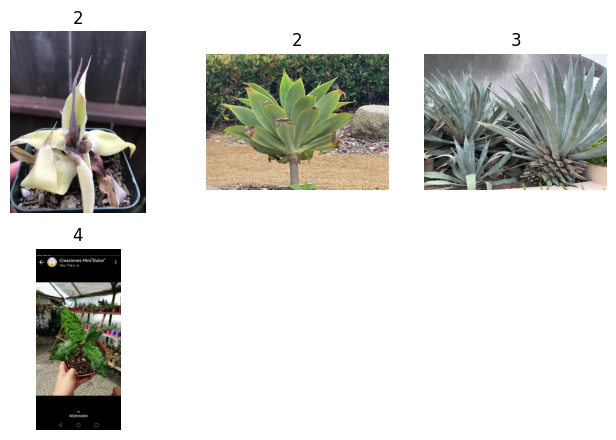

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds['image'][sample_idx], ds['label'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# 3. Оформление датасета как Dataset из Pytorch

In [35]:
to_transform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class LabelTransform:
    def __call__(self, label):
        new_label = [0] * 8
        new_label[label] = 1
        return new_label

label_to_transform = LabelTransform()
# 0 -> [1, 0, 0, 0, 0, 0, 0, 0]
# 1 -> [0, 1, 0, 0, 0, 0, 0, 0]
# ...

In [37]:
class CustomDataset(Dataset):
    def __init__(self, data, transform = None, label_transform = None):
        self.data = data
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data['image'][idx]
        label = self.data['label'][idx]
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label

custom_dataset = CustomDataset(ds, transform = to_transform, label_transform=label_to_transform)

train_size = int(0.9 * len(custom_dataset)) 
test_size = len(custom_dataset) - train_size 

train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# 4. Оформление датасета в Dataloader

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size = 40, shuffle=True, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 40, shuffle=True, num_workers = 0)

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

dataloaders = {'train': train_dataloader, 'test': test_dataloader}

# 5. Реализация и тренировка своей модели

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [46]:
device = "cpu"

In [47]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()

        epoch_loss = running_loss / len(dataset['train'])
        epoch_acc = running_corrects.double() / len(dataset['train'])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            'train', epoch_loss, epoch_acc))

      

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [48]:
model = nn.Sequential(
    nn.Conv2d(3, 4, 5),
    nn.ELU(),
    nn.MaxPool2d(2),
    nn.Conv2d(4, 16, 3),
    nn.ELU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 16, 2),

    nn.Flatten(),

    nn.Linear(80, 64), 
    nn.ELU(),
    nn.Linear(64, 8)
)

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.0022, momentum=0.9, weight_decay=0.000001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=5, gamma=0.1)

In [ ]:
model = train_model(model, dataloaders ,criterion, optimizer_sgd, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------


# 6. Обучение с помощью Transfer Learning

# 7. Метрики качества, выводы